### ייבוא חבילות 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from functools import reduce
pd.options.display.float_format = '{:,.2f}'.format

### בניית פונקציות שימושיות 

In [2]:
def FGname_var(xx):
    for objname, oid in globals().items():
        if oid is xx and not objname.startswith("_") :
            return objname
    return

In [3]:
def byhourdf(df):
    FGname_var(df)
    df2=df.copy()[(df['Timestamp'].dt.month == 10) & (df['Timestamp'].dt.day==25)]
    df2['Timestamp_RT']=df2['Timestamp'].dt.floor('H')
    return df2.groupby(df2['Timestamp_RT']).mean()

### ייבוא הדאטה (טבלאות עם נתונים שעתיים שנלקחו מאתר  blockchain.com)

In [4]:
# The total USD value of bitcoin in circulation.
market_cap = pd.read_csv('daily/market-cap.csv', parse_dates=['Timestamp'])

In [5]:
transactions_per_second= pd.read_csv('daily/transactions-per-second.csv', parse_dates=['Timestamp'])

In [6]:
total_bitcoins = pd.read_csv('daily/total-bitcoins.csv', parse_dates=['Timestamp'])

In [7]:
my_wallet_n_users = pd.read_csv('daily/my-wallet-n-users.csv', parse_dates=['Timestamp'])

In [8]:
dfs=[market_cap,transactions_per_second,total_bitcoins,my_wallet_n_users]

### ניתוח ראשוני של הדאטה

In [9]:
for df in dfs:
    print(FGname_var(df))
    print(df.dtypes)
    print('\n')
    print('Nan values')
    print(df.isnull().sum().sum())
    print(df.head(4))
    print('\n')

market_cap
Timestamp     datetime64[ns]
market-cap           float64
dtype: object


Nan values
0
            Timestamp         market-cap
0 2020-09-26 01:05:00 197,747,000,000.00
1 2020-09-26 01:26:00 198,025,000,000.00
2 2020-09-26 01:29:00 198,025,000,000.00
3 2020-09-26 01:59:00 197,442,000,000.00


transactions_per_second
Timestamp                  datetime64[ns]
transactions-per-second           float64
dtype: object


Nan values
0
            Timestamp  transactions-per-second
0 2020-09-26 15:30:00                     3.77
1 2020-09-26 16:00:00                     4.02
2 2020-09-26 16:30:00                     4.00
3 2020-09-26 17:00:00                     4.20


total_bitcoins
Timestamp         datetime64[ns]
total-bitcoins           float64
dtype: object


Nan values
0
            Timestamp  total-bitcoins
0 2020-09-27 01:05:00   18,500,968.75
1 2020-09-27 02:29:00   18,500,987.50
2 2020-09-27 03:35:00   18,501,006.25
3 2020-09-27 03:53:00   18,501,025.00


my_wallet_n_users
T

### קיבוץ נתונים לפי שעה
#### לחלק מהשדות יש יותר משורה אחת פר שעה, לכן בחרתי להשתמש בממוצע פר שעה.

In [10]:
dfs_by_h=[]
for df in dfs:
    vars()[FGname_var(df) + '_by_hour']=byhourdf(df)
    dfs_by_h.append( vars()[FGname_var(df) + '_by_hour'])
    print(FGname_var(vars()[FGname_var(df) + '_by_hour']))
    print(vars()[FGname_var(df) + '_by_hour'].tail())
    print('\n')

market_cap_by_hour
                            market-cap
Timestamp_RT                          
2020-10-25 18:00:00 240,740,000,000.00
2020-10-25 19:00:00 241,245,000,000.00
2020-10-25 20:00:00 241,741,000,000.00
2020-10-25 22:00:00 241,265,000,000.00
2020-10-25 23:00:00 241,478,666,666.67


transactions_per_second_by_hour
                     transactions-per-second
Timestamp_RT                                
2020-10-25 19:00:00                     3.33
2020-10-25 20:00:00                     3.12
2020-10-25 21:00:00                     2.83
2020-10-25 22:00:00                     2.81
2020-10-25 23:00:00                     2.42


total_bitcoins_by_hour
                     total-bitcoins
Timestamp_RT                       
2020-10-25 19:00:00   18,526,690.62
2020-10-25 20:00:00   18,526,718.75
2020-10-25 21:00:00   18,526,737.50
2020-10-25 22:00:00   18,526,765.62
2020-10-25 23:00:00   18,526,803.12


my_wallet_n_users_by_hour
                     my-wallet-n-users
Timestamp_RT   

### חיבור טבלאות ובדיקת נתונים חסרים.

In [11]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Timestamp_RT'],
                                            how='outer'), dfs_by_h)

In [12]:
df_merged.sort_values(by='Timestamp_RT', inplace=True)
df_merged.isnull().sum().sum()

4

In [13]:
df_merged[df_merged.isna().any(axis=1)]

,market-cap,transactions-per-second,total-bitcoins,my-wallet-n-users
Timestamp_RT,,,,
2020-10-25 05:00:00,nan,2.11,"18,526,268.75",55377364
2020-10-25 12:00:00,"240,751,000,000.00",3.02,nan,55386127
2020-10-25 16:00:00,nan,3.72,"18,526,606.25",55400672
2020-10-25 21:00:00,nan,2.83,"18,526,737.50",55400672


## תחקור השדות עם הערכים החסרים על מנת לבחור את הדרך הטובה ביותר למלא אותם 
#### :יש כמה שיטות, אציין רק שתיים: האחת, בהסתכלות על הגרפים למטה נראה שרגרסיה ליניארית תביא תוצאה טובה לגבי שדה
#### "total-bitcoins"
#### אבל תוצאה לא טובה לשדה
#### "market-cap"

#### שיטה נוספת היא אינטרפולציה ליניארית אשר תביא לתוצאה טובה והגיונית לשני השדות עם ערכים חסרים 

#### כאשר המשתנים רציפים עם מגמה ברורה לאורך ציר הזמן, כל פיתרון אחר כגון ממוצע או חציון יכולים לשבש לגמרי את השונות ולגרום לכך שהשדה יהפוך ללא רלוונטי סטטיסטית

In [14]:
df_merged.reset_index(inplace=True)

(array([737723.   , 737723.125, 737723.25 , 737723.375, 737723.5  ,
        737723.625, 737723.75 , 737723.875, 737724.   ]),
 <a list of 9 Text xticklabel objects>)

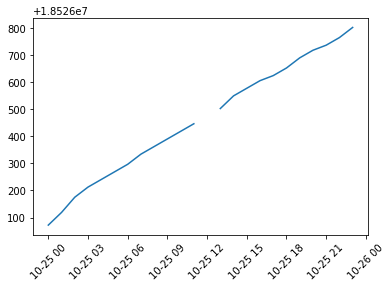

In [15]:
plt.plot(df_merged['Timestamp_RT'], df_merged['total-bitcoins'])
plt.xticks(rotation=45)

(array([737723.   , 737723.125, 737723.25 , 737723.375, 737723.5  ,
        737723.625, 737723.75 , 737723.875, 737724.   ]),
 <a list of 9 Text xticklabel objects>)

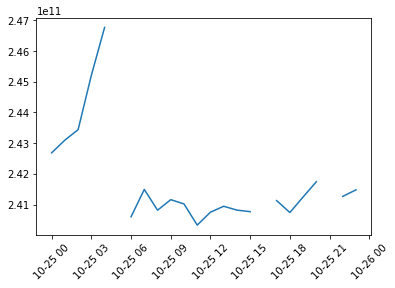

In [16]:
plt.plot(df_merged['Timestamp_RT'], df_merged['market-cap'])
plt.xticks(rotation=45)

In [17]:
df_merged["hour"]=df_merged["Timestamp_RT"].dt.hour

In [18]:
df_merged["market-cap_mus"]=(df_merged['market-cap'].shift(-1)+df_merged['market-cap'].shift(1))/2
df_merged["total-bitcoins_mus"]=(df_merged['total-bitcoins'].shift(-1)+df_merged['total-bitcoins'].shift(1))/2

In [19]:
df_merged.head(10)

,Timestamp_RT,market-cap,transactions-per-second,total-bitcoins,my-wallet-n-users,hour,market-cap_mus,total-bitcoins_mus
0,2020-10-25 00:00:00,"242,682,500,000.00",2.38,"18,526,071.88",55364970,0,nan,nan
1,2020-10-25 01:00:00,"243,097,000,000.00",2.09,"18,526,118.75",55364970,1,"243,060,500,000.00","18,526,123.44"
2,2020-10-25 02:00:00,"243,438,500,000.00",2.03,"18,526,175.00",55377364,2,"244,152,750,000.00","18,526,165.62"
3,2020-10-25 03:00:00,"245,208,500,000.00",2.06,"18,526,212.50",55377364,3,"245,101,750,000.00","18,526,207.81"
4,2020-10-25 04:00:00,"246,765,000,000.00",2.17,"18,526,240.62",55377364,4,nan,"18,526,240.62"
5,2020-10-25 05:00:00,nan,2.11,"18,526,268.75",55377364,5,"243,683,000,000.00","18,526,268.75"
6,2020-10-25 06:00:00,"240,601,000,000.00",2.31,"18,526,296.88",55377364,6,nan,"18,526,301.56"
7,2020-10-25 07:00:00,"241,490,500,000.00",2.62,"18,526,334.38",55377364,7,"240,708,000,000.00","18,526,329.69"
8,2020-10-25 08:00:00,"240,815,000,000.00",2.78,"18,526,362.50",55377364,8,"241,324,250,000.00","18,526,362.50"
9,2020-10-25 09:00:00,"241,158,000,000.00",2.83,"18,526,390.62",55386127,9,"240,917,000,000.00","18,526,390.62"


In [20]:
df_merged["market-cap"]=df_merged["market-cap"].fillna(df_merged["market-cap_mus"])
df_merged["total-bitcoins"]=df_merged["total-bitcoins"].fillna(df_merged["total-bitcoins_mus"])

In [21]:
df_merged.drop(['total-bitcoins_mus', 'market-cap_mus'], axis=1, inplace=True)

In [22]:
df_merged

,Timestamp_RT,market-cap,transactions-per-second,total-bitcoins,my-wallet-n-users,hour
0,2020-10-25 00:00:00,"242,682,500,000.00",2.38,"18,526,071.88",55364970,0
1,2020-10-25 01:00:00,"243,097,000,000.00",2.09,"18,526,118.75",55364970,1
2,2020-10-25 02:00:00,"243,438,500,000.00",2.03,"18,526,175.00",55377364,2
3,2020-10-25 03:00:00,"245,208,500,000.00",2.06,"18,526,212.50",55377364,3
4,2020-10-25 04:00:00,"246,765,000,000.00",2.17,"18,526,240.62",55377364,4
5,2020-10-25 05:00:00,"243,683,000,000.00",2.11,"18,526,268.75",55377364,5
6,2020-10-25 06:00:00,"240,601,000,000.00",2.31,"18,526,296.88",55377364,6
7,2020-10-25 07:00:00,"241,490,500,000.00",2.62,"18,526,334.38",55377364,7
8,2020-10-25 08:00:00,"240,815,000,000.00",2.78,"18,526,362.50",55377364,8
9,2020-10-25 09:00:00,"241,158,000,000.00",2.83,"18,526,390.62",55386127,9


### הסתכלות על המשתנים שבטבלה 

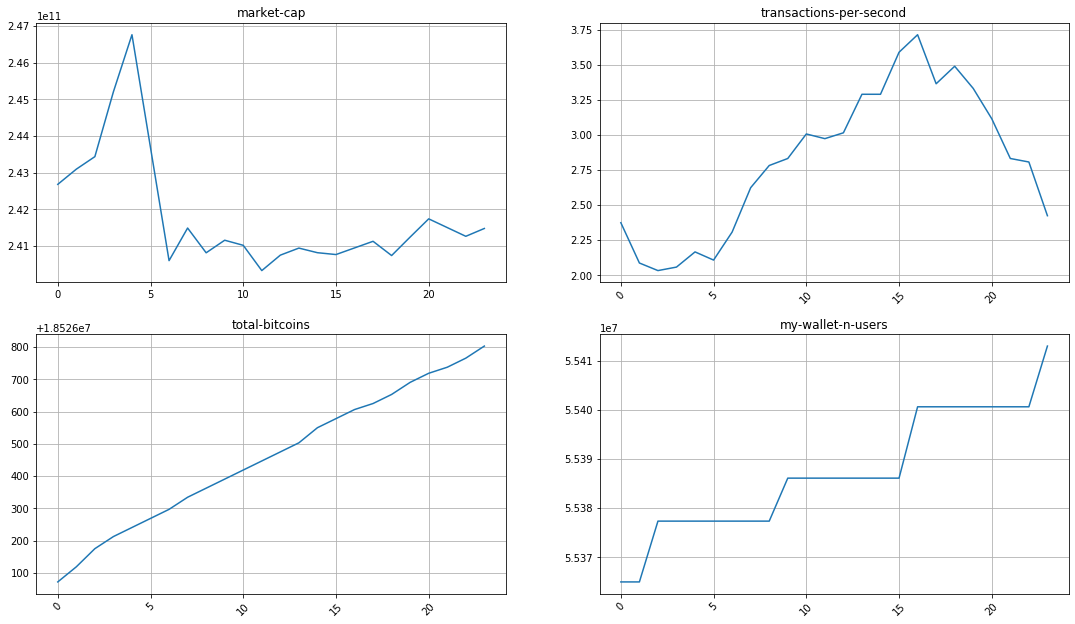

In [23]:
import numpy as np
import matplotlib.pyplot as plt


x=df_merged['hour']

fig=plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.subplot(221)
plt.plot(x, df_merged['market-cap'])
plt.yscale('linear')
plt.title('market-cap')
plt.grid(True)

plt.subplot(222)
plt.plot(x, df_merged['transactions-per-second'])
plt.yscale('linear')
plt.title('transactions-per-second')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(223)
plt.plot(x, df_merged['total-bitcoins'])
plt.yscale('linear')
plt.title('total-bitcoins')
plt.grid(True)
plt.xticks(rotation=45)

plt.subplot(224)
plt.plot(x, df_merged['my-wallet-n-users'])
plt.yscale('linear')
plt.title('my-wallet-n-users')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

###  שדה "my-wallet-n-users" בולט מאוד לעין שהוא משתנה כל 7 שעות (דבר שלא מתיישב טוב עם המציאות)  וגם שהצמיחה שלו היא ליניארית 
### אפשר להריץ רגרסיה ליניארית עבורו ולהשתמש בערכים המנובאים כל עוד הרגרסיה מובהקת

Coefficient of determination: 0.90


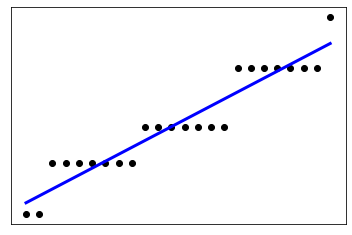

In [24]:
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
regr = linear_model.LinearRegression()
x=np.array(df_merged['hour']).reshape(-1, 1)
y=np.array(df_merged['my-wallet-n-users']).reshape(-1, 1)
regr.fit(x, y)

y_pred = regr.predict(x)

print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred))

plt.scatter(x, y,  color='black')
plt.plot(x, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### R בריבוע יצא מאד גבוה, מה שאומר שמבחינתי הרגרסיה מובהקת ואני יכול להשתמש בערכים המנובאים במקום השדה המקורי ואף לזרוק אותו מהטבלה

In [25]:
df_merged['est_wallet-n-users']=y_pred
df_merged.drop(['my-wallet-n-users'], axis=1, inplace=True)
df_merged

,Timestamp_RT,market-cap,transactions-per-second,total-bitcoins,hour,est_wallet-n-users
0,2020-10-25 00:00:00,"242,682,500,000.00",2.38,"18,526,071.88",0,"55,367,797.93"
1,2020-10-25 01:00:00,"243,097,000,000.00",2.09,"18,526,118.75",1,"55,369,482.65"
2,2020-10-25 02:00:00,"243,438,500,000.00",2.03,"18,526,175.00",2,"55,371,167.38"
3,2020-10-25 03:00:00,"245,208,500,000.00",2.06,"18,526,212.50",3,"55,372,852.10"
4,2020-10-25 04:00:00,"246,765,000,000.00",2.17,"18,526,240.62",4,"55,374,536.82"
5,2020-10-25 05:00:00,"243,683,000,000.00",2.11,"18,526,268.75",5,"55,376,221.55"
6,2020-10-25 06:00:00,"240,601,000,000.00",2.31,"18,526,296.88",6,"55,377,906.27"
7,2020-10-25 07:00:00,"241,490,500,000.00",2.62,"18,526,334.38",7,"55,379,590.99"
8,2020-10-25 08:00:00,"240,815,000,000.00",2.78,"18,526,362.50",8,"55,381,275.72"
9,2020-10-25 09:00:00,"241,158,000,000.00",2.83,"18,526,390.62",9,"55,382,960.44"


### יצירת שדות חדשים על בסיס השדות הקיימים
####  אם נחלק את ערכם של כל הביטקוין הקיימים ביחד (בדולרים) "Market_price" בכמות הביטקיון שקיימים בעולם "total-bitcoins", נקבל את ערך הביטקוין פר שעה

####  אם נחלק את סך הביטקוין "total-bitcoins	" שבשוק בסך הארנקים המנובאים "est_wallet-n-users", נקבל את  ממוצע הכמות  הביטקוין  פר ארנק בכל שעה ושעה (ערך מצופה)
#### ההפרש בין כל שורה של משתמשי ארנק ("my-wallet-n-users") לבין השורה הקודמת, נותנת לנו את כמות הארנקים החדשים או כמות הארנקים שנסגרו (אחרי שהחלפנו ערכים מקוריים עם המנובאים מהרגרסיה, ברור שהערך מיושר לגמרי)

In [26]:
df_merged['Market_price']=df_merged['market-cap']/df_merged['total-bitcoins']
df_merged['new_bitcoins']=(df_merged['total-bitcoins']-df_merged['total-bitcoins'].shift(1)).fillna(0)
df_merged['est_bit_per_wallet']=df_merged['total-bitcoins']/df_merged['est_wallet-n-users']
df_merged['est_new-users']=(df_merged['est_wallet-n-users']-df_merged['est_wallet-n-users'].shift(1)).fillna(0)

### יצירת פאנל סופי שעליו אבצע את הניתוח הסופי

In [27]:
data_to_analysis=df_merged[['hour','market-cap','transactions-per-second','total-bitcoins',\
                            'new_bitcoins','est_wallet-n-users','Market_price',\
                            'est_bit_per_wallet','est_new-users']]

In [28]:
data_to_analysis

,hour,market-cap,transactions-per-second,total-bitcoins,new_bitcoins,est_wallet-n-users,Market_price,est_bit_per_wallet,est_new-users
0,0,"242,682,500,000.00",2.38,"18,526,071.88",0.00,"55,367,797.93","13,099.51",0.33,0.00
1,1,"243,097,000,000.00",2.09,"18,526,118.75",46.88,"55,369,482.65","13,121.85",0.33,"1,684.72"
2,2,"243,438,500,000.00",2.03,"18,526,175.00",56.25,"55,371,167.38","13,140.25",0.33,"1,684.72"
3,3,"245,208,500,000.00",2.06,"18,526,212.50",37.50,"55,372,852.10","13,235.76",0.33,"1,684.72"
4,4,"246,765,000,000.00",2.17,"18,526,240.62",28.12,"55,374,536.82","13,319.76",0.33,"1,684.72"
5,5,"243,683,000,000.00",2.11,"18,526,268.75",28.12,"55,376,221.55","13,153.38",0.33,"1,684.72"
6,6,"240,601,000,000.00",2.31,"18,526,296.88",28.12,"55,377,906.27","12,987.00",0.33,"1,684.72"
7,7,"241,490,500,000.00",2.62,"18,526,334.38",37.50,"55,379,590.99","13,034.99",0.33,"1,684.72"
8,8,"240,815,000,000.00",2.78,"18,526,362.50",28.12,"55,381,275.72","12,998.50",0.33,"1,684.72"
9,9,"241,158,000,000.00",2.83,"18,526,390.62",28.12,"55,382,960.44","13,017.00",0.33,"1,684.72"


### ניתוח סטטיסטיקה תיאורית

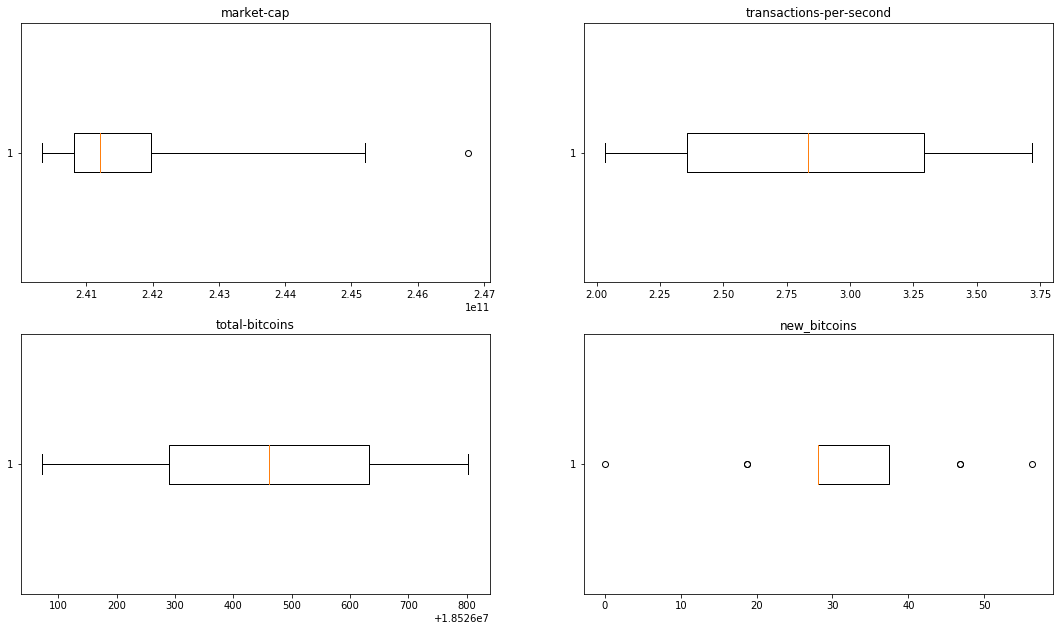

In [29]:
from pylab import *

fig=plt.figure()
fig.set_size_inches(18.5, 10.5)

subplot(221)
boxplot(data_to_analysis['market-cap'] ,vert=False, whis=4)
title('market-cap')
subplot(222)
boxplot(data_to_analysis['transactions-per-second'] ,vert=False, whis=0.75)
title('transactions-per-second')
subplot(223)
boxplot(data_to_analysis['total-bitcoins'] ,vert=False, whis=0.75)
title('total-bitcoins')
subplot(224)
boxplot(data_to_analysis['new_bitcoins'] ,vert=False, whis=0.75)
title('new_bitcoins')
show()

Text(0.5, 1.0, 'est_new-users')

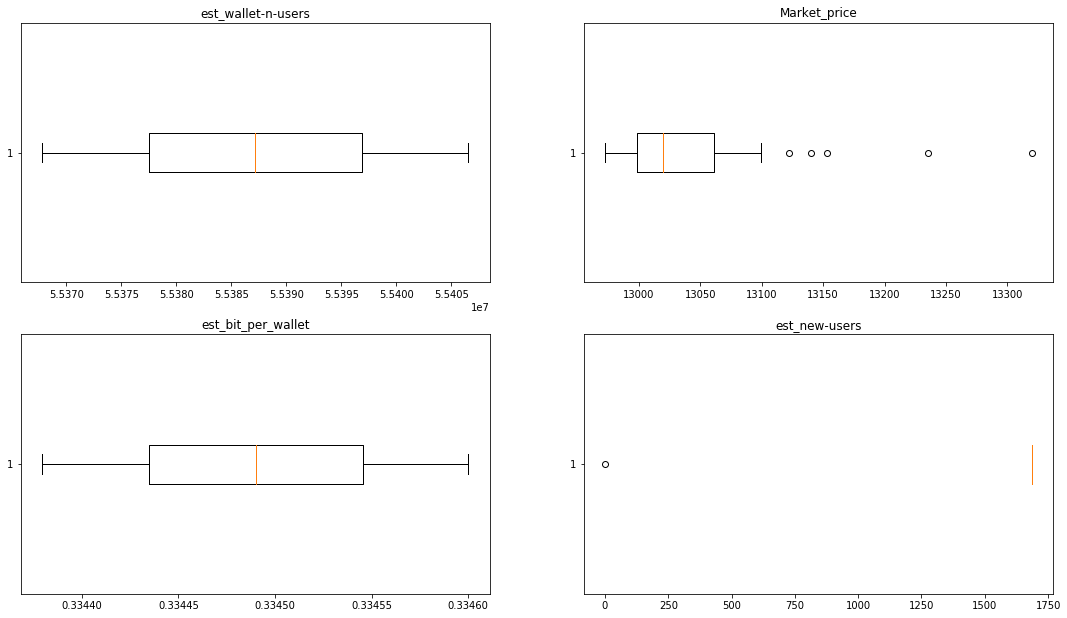

In [30]:
fig=plt.figure()
fig.set_size_inches(18.5, 10.5)

subplot(221)
boxplot(data_to_analysis['est_wallet-n-users'] ,vert=False, whis=0.75)
title('est_wallet-n-users')
subplot(222)
boxplot(data_to_analysis['Market_price'] ,vert=False, whis=0.75)
title('Market_price')
subplot(223)
boxplot(data_to_analysis['est_bit_per_wallet'] ,vert=False, whis=0.75)
title('est_bit_per_wallet')
subplot(224)
boxplot(data_to_analysis['est_new-users'] ,vert=False, whis=0.75)
title('est_new-users')

In [31]:
data_to_analysis.iloc[:,1:].describe()

,market-cap,transactions-per-second,total-bitcoins,new_bitcoins,est_wallet-n-users,Market_price,est_bit_per_wallet,est_new-users
count,24.00,24.00,24.00,24.00,24.00,24.00,24.00,24.00
mean,"241,817,302,083.33",2.82,"18,526,460.16",30.47,"55,387,172.25","13,052.54",0.33,"1,614.53"
std,"1,582,487,337.83",0.53,215.81,10.80,"11,912.79",85.50,0.00,343.89
min,"240,329,500,000.00",2.03,"18,526,071.88",0.00,"55,367,797.93","12,972.24",0.33,0.00
25%,"240,816,875,000.00",2.36,"18,526,289.84",28.12,"55,377,485.09","12,998.51",0.33,"1,684.72"
50%,"241,201,500,000.00",2.83,"18,526,460.94",28.12,"55,387,172.25","13,019.24",0.33,"1,684.72"
75%,"241,976,375,000.00",3.29,"18,526,632.03",37.50,"55,396,859.41","13,061.06",0.33,"1,684.72"
max,"246,765,000,000.00",3.72,"18,526,803.12",56.25,"55,406,546.57","13,319.76",0.33,"1,684.72"


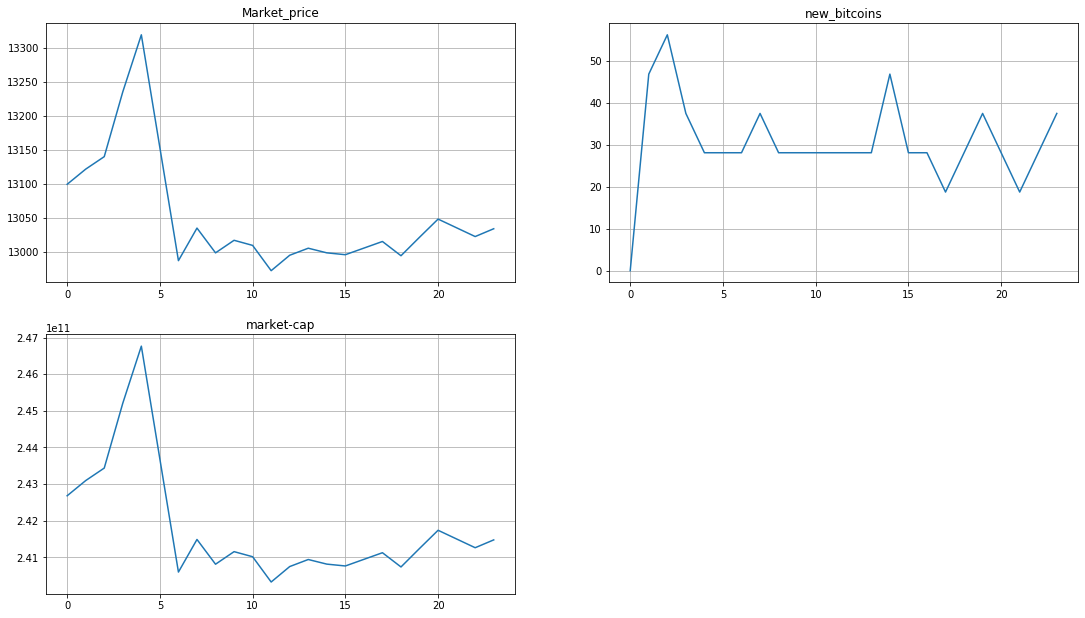

In [32]:
x=data_to_analysis['hour']

fig=plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.subplot(221)
plt.plot(x, data_to_analysis['Market_price'])
plt.yscale('linear')
plt.title('Market_price')
plt.grid(True)

plt.subplot(222)
plt.plot(x, data_to_analysis['new_bitcoins'])
plt.yscale('linear')
plt.title('new_bitcoins')
plt.grid(True)

plt.subplot(223)
plt.plot(x, data_to_analysis['market-cap'])
plt.yscale('linear')
plt.title('market-cap')
plt.grid(True)

###  מסקנות מניתוח סטטיסטיקה תיאורית:
#### אפשר להבין שמחיר הביטקוין לא יציב כל כך עם פיקים לפעמים (volatility). מה שמשתקף גם בערך כספי בדולרים של כל הביטקוין בשוק.
####  שדה כמות ביטקוינים חדשים מאד לא יציב.
#### מספר הביטקוין בשוק,  מספר הטרנזקציות ומספר הביטקוין פר ארנק יציבים.
####  שדה של מספר הארנקים החדשים המצופים הוא נבנה מהערכים המנובאים של כמות הארנקים בשוק (שמתעדכן כל כמה שעות כל פעם). מה שמביא למגמה כלפי מעלה ישרה לחלוטין של הארנקים בשוק, דבר זה מאפשר לנו רק להעריך כמה ארנקים מצטרפים פר שעה ולא נותן לנו לדעת בדיוק כמה נפתחו בפועל. כלומר, מספר הארנקים בשוק עולה בצורה יציבה וישרה ומספר הארנקים החדשים קבוע בכל שעה כי הוא השינוי הממוצע בין שעה לשעה (הדלתא Y הממוצע של קו ישר עולה). 

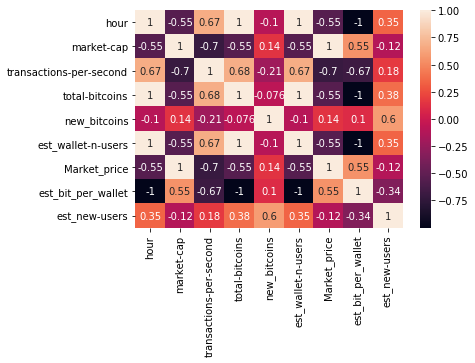

In [33]:
corrMatrix = data_to_analysis.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### מסקנות ממטריצת קורלציות:
#### כמות הביטקוין 'total-bitcoins' וכמות הארנקים 'est_wallet-n-users' בשוק עולים באופן עקבי עם מעבר השעות, וזה מתיישב מאד עם ההיגיון הכלכלי פיננסי שאומר שבזמני מלחמה ומשבר המשקיעים מעדיפים לברוח מהבורסה והמטבעות, ומתכרזים בנכסים נזילים כמה שיותר ועם כמה שפחות רגולציה (מה יותר טוב ממטבע חופשי מבנק מרכזי כשרוב החנויות המקווניות מקבלות אותו?)

#### קיים קשר שלילי חזק בין כמות ביטקוין פר ארנק 'est_bit_per_wallet' לבין כמות הארנקים 'est_wallet-n-users' וגם בין ביטקוין פר ארנק לבין כמות ביטקוין בעולם, וזה מעיד על קצב גידול חזק יותר בכמות המשקיעים  מול קצב איטי יותר בכריית המטבע. 


#### הקשר בין מחיר השוק של הביטקוין 'Market_price' לבין כמות הטרנזקציות לשניה 'transactions-per-second' יכול להסביר את המושגים  "Long" ו  "Short" אשר מניחים שבתקופות הגאות, השוק עולה לאט לאט ובמצבים של שפל השוק נופל מהר. כאשר מחיר הביטקוין עולה אז כמות הטרנזקציות יורדת, כאשר מחיר השוק יורד כמות הטרנזקציות עולה.

#### כל הקשרים האחרים בעיני הם לא חזקים (פחות מ-0.7).
